In [29]:
import cartopy.crs as ccrs
import iris
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
import numpy as np
import seaborn as sns
from scipy.stats import linregress
import xarray as xr

from mcs_prime import mcs_prime_config_util as cu

In [2]:
datadir = cu.PATHS['datadir']
simdir = datadir / 'UM_sims'

In [3]:
suites = {
    'u-dg040': 'ctrl',
    'u-dg041': 'PRIME-MCSP',
    'u-dg042': 'PRIME-stochMCSP',
}

In [4]:
def get_daily_mean_precip_flux(nc_path):
    df = xr.open_dataset(nc_path)
    tindex = xr.CFTimeIndex(df.precipitation_flux.time_1.values)
    # precipitation_flux is included twice in this stream with different time avgs.
    # Extract the daily mean values.
    tfilter = (tindex.hour == 12) & (tindex.minute == 0)
    pflux = df.precipitation_flux.isel(dim0=tfilter)
    return pflux
    
def load_suite_data(suite):
    print(suite)
    nc_paths = sorted((simdir / suite).glob(f'{suite[2:]}a.pd*.nc'))
    print(nc_paths)
    pflux = xr.concat([get_daily_mean_precip_flux(p) for p in nc_paths], dim='dim0')
    return pflux
    

In [5]:
suite_data = {
    suite: load_suite_data(suite).mean(dim='dim0')
    for suite in suites.keys()
}

u-dg040
[PosixPath('/gws/nopw/j04/mcs_prime/mmuetz/data/UM_sims/u-dg040/dg040a.pd1988dec.iris.nc'), PosixPath('/gws/nopw/j04/mcs_prime/mmuetz/data/UM_sims/u-dg040/dg040a.pd1988nov.iris.nc'), PosixPath('/gws/nopw/j04/mcs_prime/mmuetz/data/UM_sims/u-dg040/dg040a.pd1988oct.iris.nc'), PosixPath('/gws/nopw/j04/mcs_prime/mmuetz/data/UM_sims/u-dg040/dg040a.pd1988sep.iris.nc'), PosixPath('/gws/nopw/j04/mcs_prime/mmuetz/data/UM_sims/u-dg040/dg040a.pd1989apr.iris.nc'), PosixPath('/gws/nopw/j04/mcs_prime/mmuetz/data/UM_sims/u-dg040/dg040a.pd1989aug.iris.nc'), PosixPath('/gws/nopw/j04/mcs_prime/mmuetz/data/UM_sims/u-dg040/dg040a.pd1989feb.iris.nc'), PosixPath('/gws/nopw/j04/mcs_prime/mmuetz/data/UM_sims/u-dg040/dg040a.pd1989jan.iris.nc'), PosixPath('/gws/nopw/j04/mcs_prime/mmuetz/data/UM_sims/u-dg040/dg040a.pd1989jul.iris.nc'), PosixPath('/gws/nopw/j04/mcs_prime/mmuetz/data/UM_sims/u-dg040/dg040a.pd1989jun.iris.nc'), PosixPath('/gws/nopw/j04/mcs_prime/mmuetz/data/UM_sims/u-dg040/dg040a.pd1989mar.i

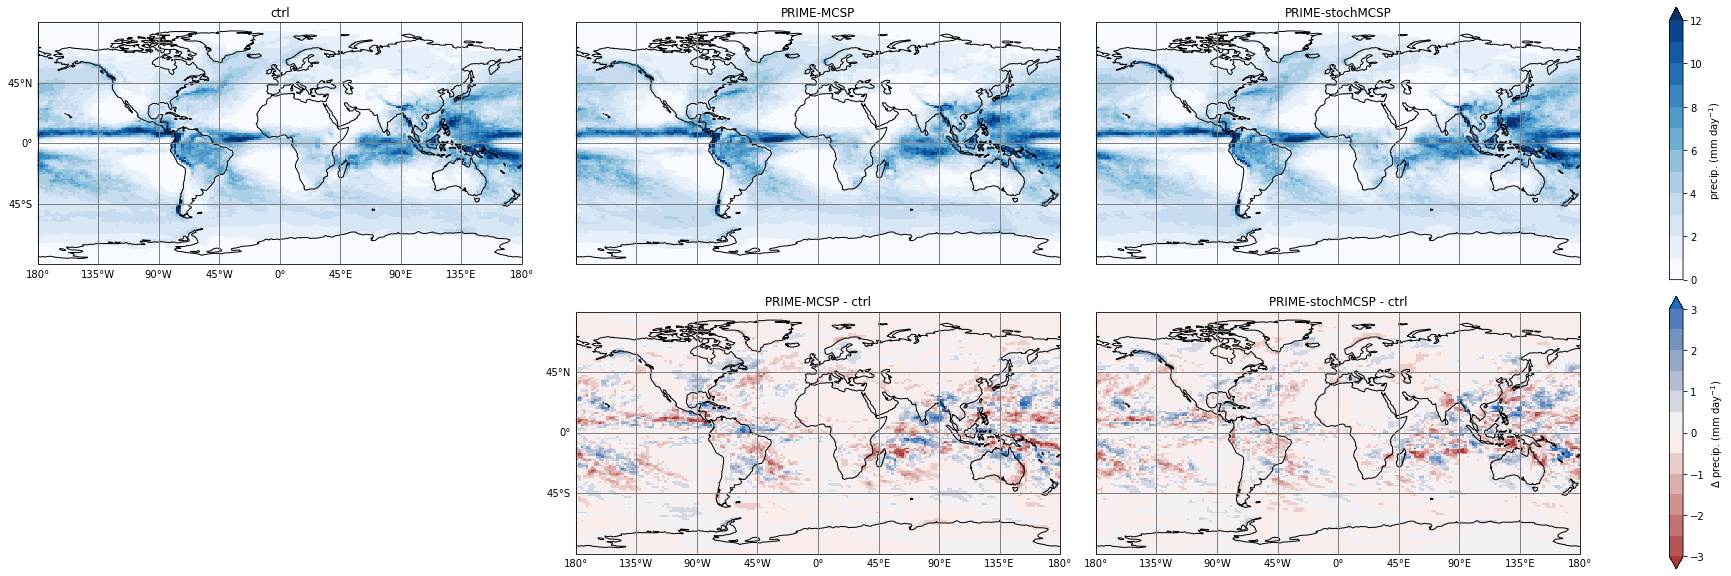

In [20]:
def plot_suites(suites, suite_data):
    fig, axes = plt.subplots(2, 3, subplot_kw={'projection': ccrs.PlateCarree()}, layout='constrained')
    fig.set_size_inches((24, 8))
    cubehelix = sns.color_palette('cubehelix_r', as_cmap=True)
    vlag = sns.color_palette('vlag_r', as_cmap=True)
    axes[1, 0].axis('off')
    for suite, ax in zip(suites.keys(), axes[0]):
        pflux = suite_data[suite]
        im = (pflux * 3600 * 24).plot(ax=ax, cmap='Blues', levels=np.linspace(0, 12, 13), add_colorbar=False)
        ax.set_title(suites[suite])
        if suites[suite] == 'ctrl':
            ctrl_pflux = pflux
        ax.coastlines()
    plt.colorbar(im, ax=axes[0], label='precip. (mm day$^{-1}$)')
    for suite, ax in zip(suites.keys(), axes[1]):
        if suites[suite] == 'ctrl':
            continue
        pflux = suite_data[suite]
        im = (pflux * 3600 * 24 - ctrl_pflux * 3600 * 24).plot(ax=ax, cmap=vlag, levels=np.linspace(-3, 3, 13), add_colorbar=False)
        ax.set_title(f'{suites[suite]} - ctrl')
        ax.coastlines()
    plt.colorbar(im, ax=axes[1], label='$\Delta$ precip. (mm day$^{-1}$)')

    for ax in axes[0, 1:]:
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, color='gray')
        gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 45))
        gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 45))
    for idx in [(0, 0), (1, 1), (1, 2)]:
        ax = axes[idx]
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray')
        gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 45))
        gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 45))
        gl.top_labels = False
        gl.right_labels = False
        if idx == (1, 2):
            gl.left_labels = False
            

plot_suites(suites, suite_data)

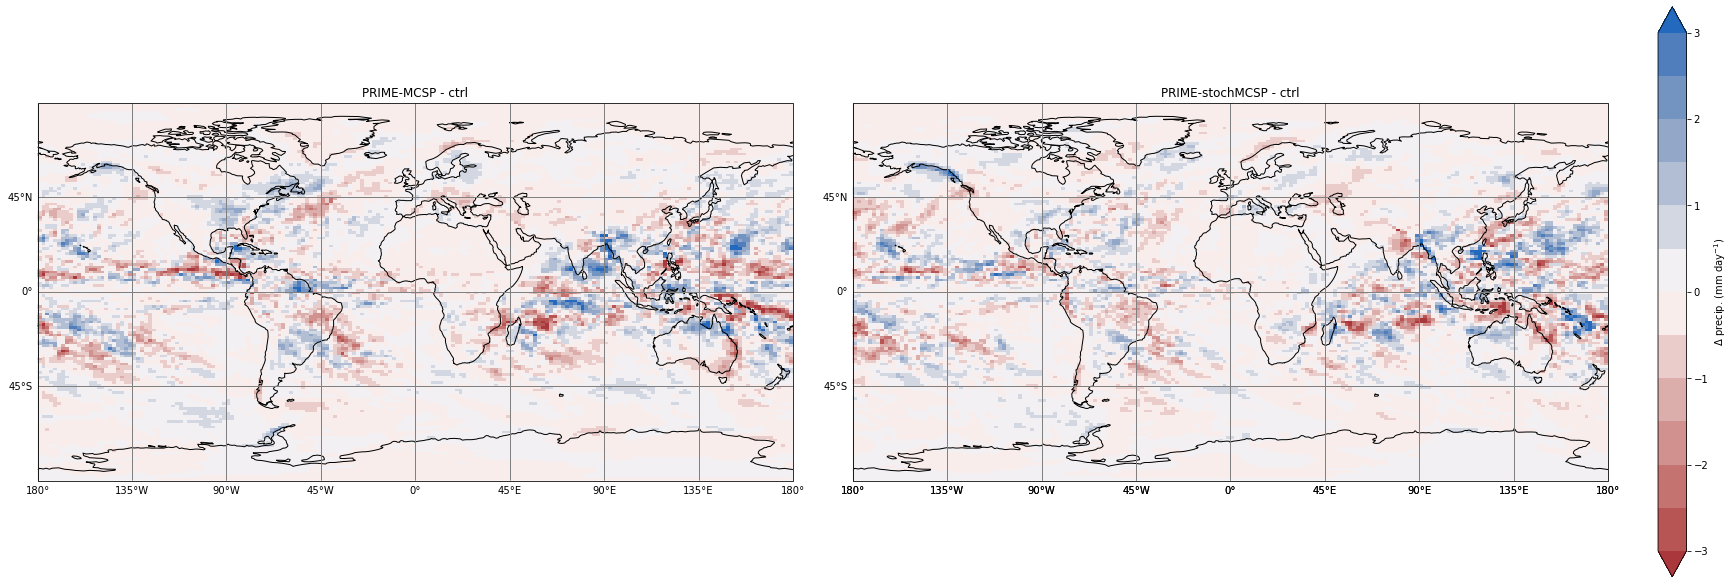

In [42]:
def plot_suites_diff_only(suites, suite_data):
    fig, axes = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree()}, layout='constrained')
    fig.set_size_inches((24, 8))
    vlag = sns.color_palette('vlag_r', as_cmap=True)
    ctrl_pflux = suite_data['u-dg040']
    for suite, ax in zip(['u-dg041', 'u-dg042'], axes):
        if suites[suite] == 'ctrl':
            continue
        pflux = suite_data[suite]
        im = (pflux * 3600 * 24 - ctrl_pflux * 3600 * 24).plot(ax=ax, cmap=vlag, levels=np.linspace(-3, 3, 13), add_colorbar=False)
        ax.set_title(f'{suites[suite]} - ctrl')
        ax.coastlines()
    plt.colorbar(im, ax=axes[1], label='$\Delta$ precip. (mm day$^{-1}$)')

    for ax in axes[1:]:
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray')
        gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 45))
        gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 45))
        gl.top_labels = False
        gl.right_labels = False
        gl.left_labels = False
    for ax in axes[0:]:
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray')
        gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 45))
        gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 45))
        gl.top_labels = False
        gl.right_labels = False         

plot_suites_diff_only(suites, suite_data)

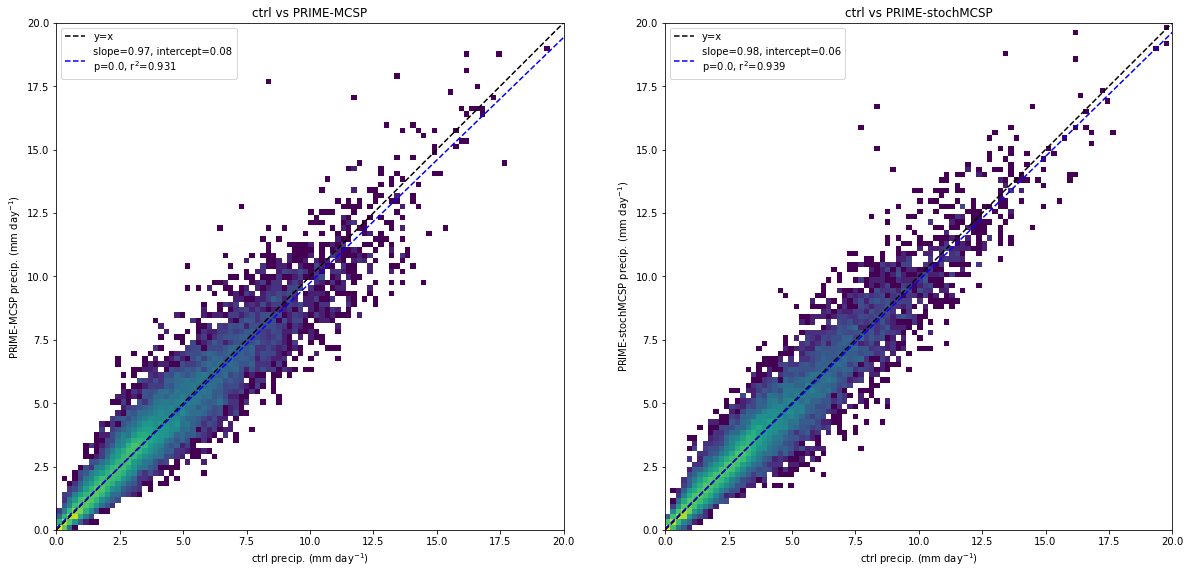

In [39]:
def plot_corr(suites, suite_data):
    ctrl_pflux = suite_data['u-dg040']
    fig, axes = plt.subplots(1, 2)
    fig.set_size_inches(20, 10)
    for ax, suite in zip(axes, ['u-dg041', 'u-dg042']):
        ax.set_title(f'ctrl vs {suites[suite]}')
        pflux = suite_data[suite]
        lr = linregress(ctrl_pflux.values.flatten() * 3600 * 24, pflux.values.flatten() * 3600 * 24)
        # plt.scatter(ctrl_pflux.values.flatten() * 3600 * 24, pflux.values.flatten() * 3600 * 24)
        ax.hist2d(ctrl_pflux.values.flatten() * 3600 * 24, pflux.values.flatten() * 3600 * 24, bins=(100, 100), norm=LogNorm())
        ax.plot([0, 20], [0, 20], 'k--', label='y=x')
        ax.set_aspect('equal')
        ax.set_xlim((0, 20))
        ax.set_ylim((0, 20))
        x = np.array([0, 20])
        y = lr.slope * x + lr.intercept
        ax.plot(x, y, 'b--', label=f'slope={lr.slope:.2f}, intercept={lr.intercept:.2f}\np={lr.pvalue}, r$^2$={lr.rvalue**2:.3f}')
        ax.legend()
        ax.set_xlabel('ctrl precip. (mm day$^{-1}$)')
        ax.set_ylabel(suites[suite] + ' precip. (mm day$^{-1}$)')
        
plot_corr(suites, suite_data)

In [54]:
import pickle
import matplotlib as mpl
def load_cmap_data(cmap_data_filename):
    with open(cmap_data_filename, 'rb') as fp:
        cmap_data = pickle.load(fp)
        if cmap_data_filename == 'percent_11lev_labelbar.pkl':
            cmap = mpl.colors.ListedColormap(cmap_data['html_colours'][1:])
        else:
            cmap = mpl.colors.ListedColormap(cmap_data['html_colours'])
        norm = mpl.colors.BoundaryNorm(cmap_data['bounds'], cmap.N)
        cbar_kwargs = cmap_data['cbar_kwargs']
    return cmap, norm, cmap_data['bounds'], cbar_kwargs




In [55]:
cmap, norm, bounds, cbar_kwargs = load_cmap_data('percent_11lev_labelbar.pkl')
cmap2, _, _, _ = load_cmap_data('zhang_precip_diff.pkl')

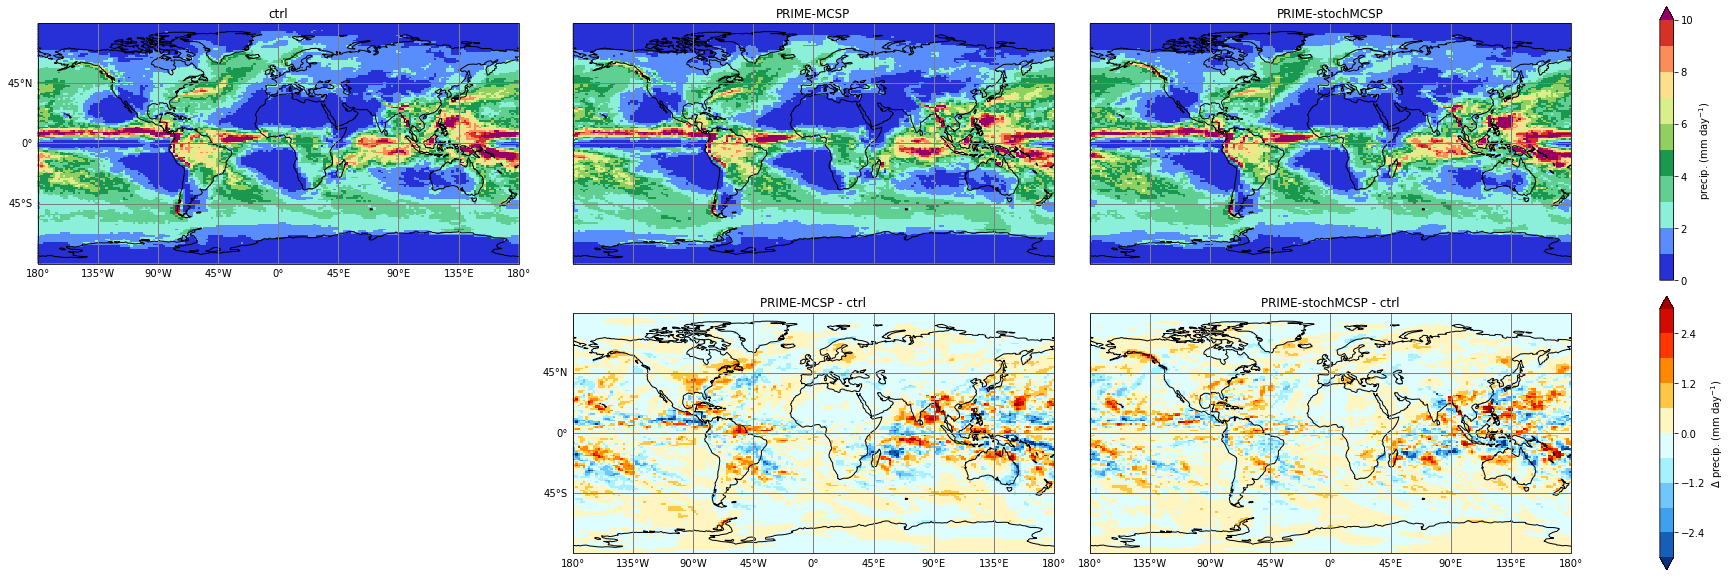

In [61]:
def plot_suites2(suites, suite_data):
    fig, axes = plt.subplots(2, 3, subplot_kw={'projection': ccrs.PlateCarree()}, layout='constrained')
    fig.set_size_inches((24, 8))
    cubehelix = sns.color_palette('cubehelix_r', as_cmap=True)
    vlag = sns.color_palette('vlag_r', as_cmap=True)
    axes[1, 0].axis('off')
    for suite, ax in zip(suites.keys(), axes[0]):
        pflux = suite_data[suite]
        im = (pflux * 3600 * 24).plot(ax=ax, cmap=cmap, levels=np.linspace(0, 10, 11), add_colorbar=False)
        ax.set_title(suites[suite])
        if suites[suite] == 'ctrl':
            ctrl_pflux = pflux
        ax.coastlines()
    plt.colorbar(im, ax=axes[0], label='precip. (mm day$^{-1}$)')
    for suite, ax in zip(suites.keys(), axes[1]):
        if suites[suite] == 'ctrl':
            continue
        pflux = suite_data[suite]
        im = (pflux * 3600 * 24 - ctrl_pflux * 3600 * 24).plot(ax=ax, cmap=cmap2, levels=np.linspace(-3, 3, 11), add_colorbar=False)
        ax.set_title(f'{suites[suite]} - ctrl')
        ax.coastlines()
    plt.colorbar(im, ax=axes[1], label='$\Delta$ precip. (mm day$^{-1}$)')

    for ax in axes[0, 1:]:
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, color='gray')
        gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 45))
        gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 45))
    for idx in [(0, 0), (1, 1), (1, 2)]:
        ax = axes[idx]
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray')
        gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 45))
        gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 45))
        gl.top_labels = False
        gl.right_labels = False
        if idx == (1, 2):
            gl.left_labels = False
            

plot_suites2(suites, suite_data)

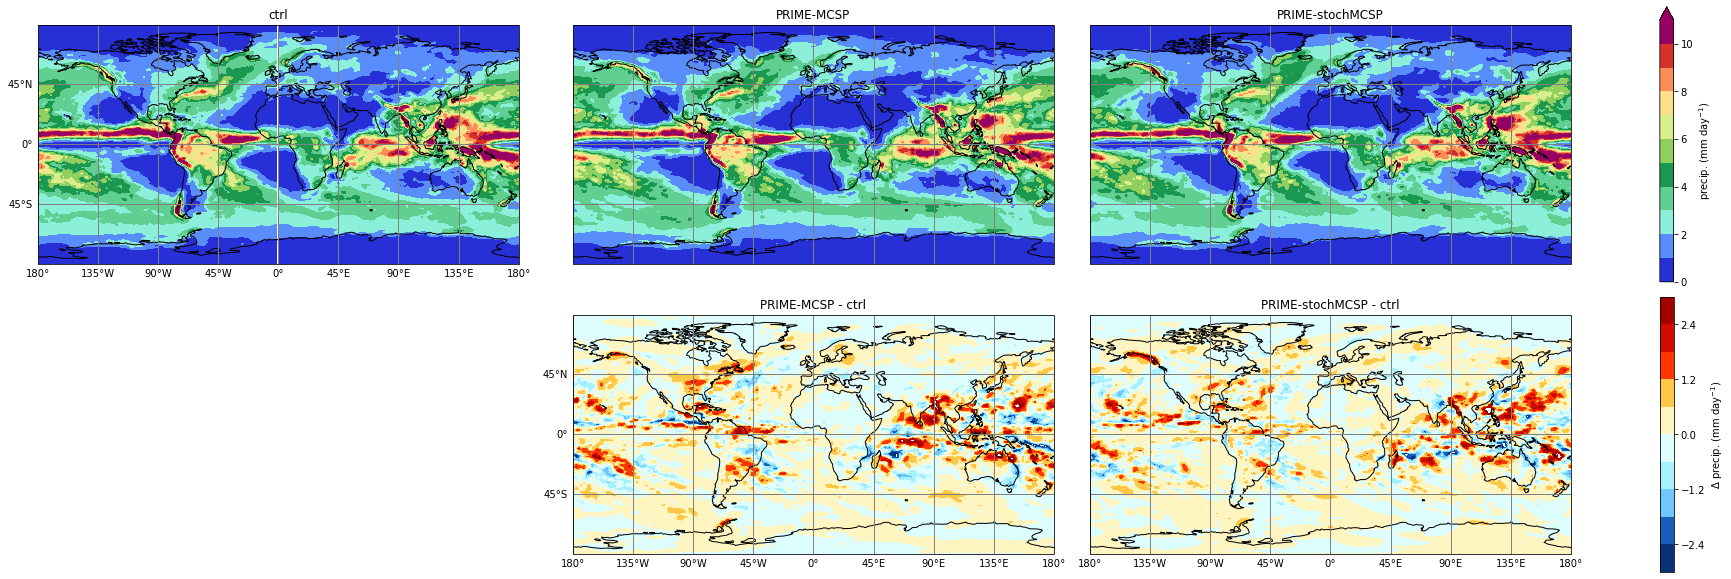

In [67]:
def plot_suites3(suites, suite_data):
    fig, axes = plt.subplots(2, 3, subplot_kw={'projection': ccrs.PlateCarree()}, layout='constrained')
    fig.set_size_inches((24, 8))
    cubehelix = sns.color_palette('cubehelix_r', as_cmap=True)
    vlag = sns.color_palette('vlag_r', as_cmap=True)
    axes[1, 0].axis('off')
    for suite, ax in zip(suites.keys(), axes[0]):
        pflux = suite_data[suite]
        # im = (pflux * 3600 * 24).plot(ax=ax, cmap=cmap, levels=np.linspace(0, 10, 11), add_colorbar=False)
        im = ax.contourf(pflux.longitude, pflux.latitude, pflux * 3600 * 24, cmap=cmap, levels=np.linspace(0, 11, 12), extend='max')
        ax.set_title(suites[suite])
        if suites[suite] == 'ctrl':
            ctrl_pflux = pflux
        ax.coastlines()
    plt.colorbar(im, ax=axes[0], label='precip. (mm day$^{-1}$)')
    for suite, ax in zip(suites.keys(), axes[1]):
        if suites[suite] == 'ctrl':
            continue
        pflux = suite_data[suite]
        # im = (pflux * 3600 * 24 - ctrl_pflux * 3600 * 24).plot(ax=ax, cmap=cmap2, levels=np.linspace(-3, 3, 11), add_colorbar=False)
        im = ax.contourf(pflux.longitude, pflux.latitude, pflux * 3600 * 24 - ctrl_pflux * 3600 * 24, cmap=cmap2, levels=np.linspace(-3, 3, 11))
        ax.set_title(f'{suites[suite]} - ctrl')
        ax.coastlines()
    plt.colorbar(im, ax=axes[1], label='$\Delta$ precip. (mm day$^{-1}$)')

    for ax in axes[0, 1:]:
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, color='gray')
        gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 45))
        gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 45))
    for idx in [(0, 0), (1, 1), (1, 2)]:
        ax = axes[idx]
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray')
        gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 45))
        gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 45))
        gl.top_labels = False
        gl.right_labels = False
        if idx == (1, 2):
            gl.left_labels = False
            

plot_suites3(suites, suite_data)

In [7]:
raise Exception('dev code below')

Exception: dev code below

In [ ]:
pflux0 = suite_data['u-dg040']

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
fig.set_size_inches((12, 5))
(pflux0 * 3600 * 24).plot(ax=ax, cmap='plasma', levels=np.linspace(0, 15, 16), add_colorbar=False)
ax.set_title('ctrl')
ax.coastlines()

In [ ]:
pd_paths = sorted((simdir / 'u-dg040').glob('dg040a.pd*.pp'))
nc_paths = sorted((simdir / 'u-dg040').glob('dg040a.pd*.nc'))

In [ ]:
# df = xr.open_mfdataset(nc_paths)


In [ ]:
# Necessary to get just precipitation_flux that has been averaged daily.
pflux_hour_12 = iris.Constraint(name='precipitation_flux', time=lambda cell: (cell.point.hour == 12) and (cell.point.minute == 0))
cubes = iris.load(pd_paths[:3], constraints=pflux_hour_12)

In [ ]:
pflux_cube = cubes[0]
da = xr.DataArray.from_iris(pflux_cube)

In [ ]:
df = xr.open_dataset(nc_paths[0])
tindex = xr.CFTimeIndex(df.precipitation_flux.time_1.values)
tfilter = (tindex.hour == 12) & (tindex.minute == 0)
pflux = df.precipitation_flux.isel(dim0=tfilter)
pflux

In [ ]:
def get_daily_mean_precip_flux(nc_path):
    df = xr.open_dataset(nc_path)
    tindex = xr.CFTimeIndex(df.precipitation_flux.time_1.values)
    tfilter = (tindex.hour == 12) & (tindex.minute == 0)
    pflux = df.precipitation_flux.isel(dim0=tfilter)
    return pflux

In [ ]:
pflux = xr.concat([get_daily_mean_precip_flux(p) for p in nc_paths], dim='dim0')

In [ ]:
pflux.mean(dim='dim0').plot()